## Introduction to Bloom Filters

A bloom filter is a probabilistic data structure that can be used to determine if an element belongs to a set. However, a bloom filter can only check if an element is "possibly in the set" or "definitely not in the set."

Since the bloom filter uses hashing, it is a space-efficient data structure, but the efficiency of the data structure comes with a tradeoff in accuracy. The probabilistic characteristic of bloom filters means that false positives are possible. Thus, the filter might wrongly determine that an element is in a set, although it is not. However, false negatives will not happen, which means that we will know for sure if an element is not in the set. 


### The Algorithm and its Limitations

A bloom filter is made of a bit-vector of length $m$. Thus, it only consists of 0 or 1-bit values, and all of the values are initialized at 0. When we want to insert an element, we pass it through a certain number of different hash functions, $k$, and then set the indices at the hashed values to 1. We repeat this procedure for the next element. During this operation, we might mark an index that was also marked when we inserted the first element. If we want to check if the CBF contains a third element, then there are two possible outcomes:

1. One of the hash functions gives us an index marked with a 0. Thus, we know that the element is "definitely not" in our the CBF.
2. We hash indices all marked with a 1. However, we can only say that the third element is "maybe" in our list because the indices could have been incremented by other data. The latter is the case here, so we have a false positive case.

The bloom filter does not support deletion. If we reset the index counters from 1 to 0, it can lead to collisions as already-stored items might hash to the indices we reset.

### Complexity

When we hash an element, it will take constant time, $O(1)$. Furthermore, we also have constant space complexity because we do not alter the size of the filter after it has been initialized. 

### False Positive Rate

Let the false positive rate be denoted by $p$, the memory size/number of indices be denoted by $m$, the fixed number of hash functions be denoted by $k$, and inserted elements be denoted by $n$.  

If we assume that there is a uniform probability that the hash functions hash to specific indices in the CBF, then the probability of a counter being incremented is given by:  
<br />  
$\frac{1}{m}$  
<br />  
Therefore, the opposite probability, that a bucket will not be incremented, is given by  
<br />  
$1-(\frac{1}{m})$  
<br />  
If we take this probability for k hash functions, then the probability becomes:  
<br />  
$(1-\frac{1}{m})^k$  
<br />  
Furthermore, if we have n independent elements that we want to insert into the CBF, then the probability that a counter has not been incremented will be given by:  
<br />  
$(1-\frac{1}{m})^{kn}$  
<br />  
We can, therefore, say that the probability that a counter has been incremented is:  
<br />  
$1-(1-\frac{1}{m})^{kn}$  
<br />  
However, we have $k$ hash functions which means that we then get:  
<br />  
$p=(1-(1-\frac{1}{m})^{kn})^k$  
<br />  
which is the false positive rate.  

### Size  and Hash Functions

Given the same variables as above, the optimal size of the bloom filter is given by:  
<br />  
$m=-\frac{nlnp}{(ln2)^2}$  
<br />  
Furthermore, the optimal number of hash functions that minimizes the false positive rate is:  
<br />  
$k=\frac{m}{n}ln2=-\log_2 p$

## Overview of Counting Bloom Filter

A counting bloom filter (CBF) is a variation of a bloom filter that allows us to update the set both through insertion and deletion of elements. The counting bloom filter uses n-bit integers (index counters) to represent the $m$ elements instead of bit-sized integers (only 0 and 1).

When an element is added or deleted, we still apply all $k$ hash functions. However, now we increment the index counter by 1 when we add an element or decrement index counter by 1 when we delete an element.


## CBFs Operations

Initially, all of the buckets in the CBF start at a threshold (in this case zero).

### Insertion

When we want to add an element, $x$, to the CBF, we run it through each of the $k$ hash functions to get all index positions. We then increment the counters at these indices by 1. 

### Contains

When we want to search for an element, $x$, we obtain the hash value for each of the $k$ hash functions. Afterward, we retrieve the corresponding indices in our CBF and start examining the counters. If all of the counters are greater than zero, then we can say that the element is probably in the CBF. However, if any of the counters are zero, then we know that the element is definitely not in the CBF. 

### Deletion

When we want to delete an element, $x$, from the CBF, we first query for the element as described above to check if the element is actually in CBP. If we know that the element is definitely not in the CBF, then we do not continue. Otherwise, we obtain each hash value of $x$ from the $k$ hash functions and retrieve the corresponding CBF indices. Lastly, each of these indices' counters are decremented by 1.     

## Computational Applications of CBF

### Username Creation

Usernames usually need to be unique. Therefore, when a user creates a username, we want to be entirely sure that it is not already taken, which a CBF can signal. In this context, a false positive would happen when the user is told that a username exists although it does not. However, this can also be tolerated because the user would still be able to use a different username. 

### Database Search

We might have a program that needs to search for a specific element in a database. For example, we might have to search if a customer's phone number is in a customer database. Initially, we can use a CBF to determine if the phone number is definitely not there. However, if the CBF determines that the phone number is there, the computer should move on to a different method to determine if we have a false positive or not. The benefit here is that the search with the CBF is very quick, $O(1)$, and we can tolerate having to use a slower method to double-check if we have a false positive. 

### Note on Implementation

I have two different implementations of the counting bloom filter. The "CPF_formulas(object)" takes the number of items to insert and the false positive rate as inputs and determines the optimal size and number of hash functions based on the equations above. However, for the later analysis, I found out that it would be better also to have an implementation that allowed the user to input a set number of hash functions ("CBF(object)") to keep this number constant. In this case, the size is equal to the number of items we plan to insert.

### Importing Packages and Libraries

In [2]:
import math
import mmh3
import matplotlib.pyplot as plt
import random
import string
import time

### First Implementation: Calculates Optimal Size and Hash Functions

In [3]:
class CBF_formulas(object):
    def __init__(self, number_items, fpr):
        """Creating a class with an array length determined based on the 
        optimal size equation and a number of hash functions based on the
        equation for the optimal hash function number.""" 
        self.array = self.size_determine(number_items, fpr) 
        self.functions_number = self.optimal_functions(fpr)
        self.size = len(self.array) 

    def size_determine(self, number_items, fpr):
        """Determining the appropriate size of the array. We use the formula
        size = -(n*ln(fpr))/(ln(2)^2). Afterward, we create an array of the determined
        size and initialize all elements at 0."""
        
        size = int(-(number_items * math.log(fpr)) / (math.log(2) ** 2))
        array = [0 for i in range(size)]
        return array 

    def optimal_functions(self, fpr):
        """Determining the optimal number of hash functions based on the false
        positive rate. We use the formula: hash functions no. = -log base 2 (p)."""
        
        optimal_number = int(- math.log(fpr, 2))
        
        # If the optimal number is less than 1, we use one hash function.
        if optimal_number < 1:
            optimal_number = 1
        
        return optimal_number
    
    def hash_functions_formulas(self, item):
        """Finding the hashed values of the items. We use the mmh3 library and then find 
        the modulus of the returned value with respect to the size of the array."""
        
        # Initializing a list to store the functions:
        functions_list_formulas = []
        
        # We need to find the hashed value of the item for each hash function.
        for i in range(0, self.functions_number):
            
            # Appending the hashed values to the functions list. 
            # We use the default mmh3 hash function with i as the seed. 
            # Lastly, we divide by the mod of the array's size to ensure that we do not get 
            # indices above or below the array's indices. 
            functions_list_formulas.append(mmh3.hash(item, i) % self.size)
        
        return functions_list_formulas
        
    def add_formulas(self, item):
        """Function for adding an item to the CBF. For each index we found in the hash function 
        we increase the counter by one."""
        
        # Going through all the indices we found in the hash functions.
        for function in self.hash_functions_formulas(item):
            
            hash_index = function 
            self.array[hash_index] += 1 # Increasing the index counter by one.
        
    def contains_formulas(self, item):
        """Function for searching for an item in the CBF. We go through each index found with 
        the hash function(s) and check if any of the indices are equal to zero. If at least
        one of the indices are equal to zero, we know that the element is not there. However, 
        if none of them equal zero we can only say that the element is possibly there."""
        
        # Going through every index value found with the hash functions.
        for function in self.hash_functions_formulas(item):
            hash_index = function
            if self.array[hash_index] == 0: 
                # If an index is 0, we know that the element is not in the array, so we return False.
                return False
            
        return True # The element is possibly in the set. However, we use True to make later analysis easier.
    
    def delete_formulas(self, item):
        """Function for deleting an item from the CBF. We first need to check if the element
        is in the array with the contains function. """
        
        # First we need to check if the item is in the CBF. Since the contains function returns False
        # if the element is not there, then we will only enter the following loop if the element is 
        # potentially in the array.
        if self.contains_formulas(item):
            
            # Going through every index value found with the hash functions.
            for function in self.hash_functions_formulas(item):
                hash_index = function
                
                #if self.array[hash_index] == 0:
                    #raise Exception("The element is not the CBF, so it cannot be removed.")
                
                #else:
                # Decreasing the index counter at the indices from the hash functions we iterate over. 
                self.array[hash_index] -= 1 
        

### First Implementation: Testing

In [4]:
# Creating a CBG for 5 elements with a fpr = 0.1.
B1 = CBF_formulas(5, 0.1)
print("The initial array:", B1.array)
print("The size of the array:", B1.size)
print("Optimal number of hash functions:", B1.functions_number)

# Checking the array length and the size:
assert(len(B1.array)==B1.size)

# Adding an element.
B1.add_formulas("Word")
print("Indices for the element:", B1.hash_functions_formulas("Word"))
print("The array after adding", B1.array)

# Checking if we have correctly increased the counters at the indices for the word.
for index in B1.hash_functions_formulas("Word"):
    if B1.array[index] == 0: 
        raise Exception

# Checking if the element is there.
assert B1.contains_formulas("Word")

# Checking if a different element is not there.
assert not B1.contains_formulas("Number")

# Deleting the first element.
B1.delete_formulas("Word")
print("The array after deleting:", B1.array)

# Checking if we have correctly deleted the word.
for index in B1.hash_functions_formulas("Word"):
    # Since we deleted the only word, all indices should have a 0. 
    if B1.array[index] != 0: 
        raise Exception

The initial array: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
The size of the array: 23
Optimal number of hash functions: 3
Indices for the element: [4, 19, 10]
The array after adding [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
The array after deleting: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Second Implementation: Constant Number of Hash Functions

In [5]:
class CBF(object):
    def __init__(self, number_items, hash_functions):
        """Creating a class with the input array length hash functions number.""" 
        self.array = [0 for i in range(number_items)]
        self.hash_functions_number = hash_functions
        self.size = len(self.array) 
    
    def hash_functions(self, item):
        """Finding the hashed values of the items. We use the mmh3 library and then find 
        the modulus of the returned value with respect to the size of the array."""
        
        # Initializing a list to store the functions:
        functions_list = []
        
        # We need to find the hashed value of the item for each hash function.
        for i in range(0, self.hash_functions_number):
            
            # Appending the hashed values to the functions list. 
            # We use the default mmh3 hash function with i as the seed. 
            # Lastly, we divide by the mod of the array's size to ensure that we do not get 
            # indices above or below the array's indices. 
            functions_list.append(mmh3.hash(item, i) % self.size)
        
        return functions_list
        
    def add(self, item):
        """Function for adding an item to the CBF. For each index we found in the hash function 
        we increase the counter by one."""
        
        # Going through all the indices we found in the hash functions.
        for function in self.hash_functions(item):
            
            hash_index = function 
            self.array[hash_index] += 1 # Increasing the index counter by one.
        
    def contains(self, item):
        """Function for searching for an item in the CBF. We go through each index found with 
        the hash function(s) and check if any of the indices are equal to zero. If at least
        one of the indices are equal to zero, we know that the element is not there. However, 
        if none of them equal zero we can only say that the element is possibly there."""
        
        # Going through every index value found with the hash functions.
        for function in self.hash_functions(item):
            hash_index = function
            if self.array[hash_index] == 0: 
                # If an index is 0, we know that the element is not in the array, so we return False.
                return False
            
        return True # The element is possibly in the set. However, we use True to make later analysis easier.
    
    def delete(self, item):
        """Function for deleting an item from the CBF. We first need to check if the element
        is in the array with the contains function. """
        
        # First we need to check if the item is in the CBF. Since the contains function returns False
        # if the element is not there, then we will only enter the following loop if the element is 
        # potentially in the array.
        if self.contains(item):
            
            # Going through every index value found with the hash functions.
            for function in self.hash_functions(item):
                hash_index = function
                
                # Decreasing the index counter at the indices from the hash functions we iterate over. 
                self.array[hash_index] -= 1 
        

### Second Implementation: Testing

In [6]:
# Creating a CBG for 5 elements with a fpr = 0.1.
B1 = CBF(5, 3)
print("The initial array:", B1.array)
print("The size of the array:", B1.size)
print("Number of hash functions", B1.hash_functions_number)

# Checking the array length and the size:
assert(len(B1.array)==B1.size)

# Adding an element.
B1.add("Word")
print("Indices for the element:", B1.hash_functions("Word"))
print("The array after adding", B1.array)

# Checking if we have correctly increased the counters at the indices for the word.
for index in B1.hash_functions("Word"):
    if B1.array[index] == 0: 
        raise Exception

# Checking if the element is there.
assert B1.contains("Word")

# Checking if a different element is not there.
assert not B1.contains("Number")

# Deleting the first element.
B1.delete("Word")
print("The array after deleting:", B1.array)

# Checking if we have correctly deleted the word.
for index in B1.hash_functions("Word"):
    # Since we deleted the only word, all indices should have a 0. 
    if B1.array[index] != 0: 
        raise Exception

The initial array: [0, 0, 0, 0, 0]
The size of the array: 5
Number of hash functions 3
Indices for the element: [2, 0, 3]
The array after adding [1, 0, 1, 1, 0]
The array after deleting: [0, 0, 0, 0, 0]


## Justification of Hash Functions Choice

The CBF implementation uses MurmurHash for hashing (mmh3). When we call mmh3.hash("element"), we will get a 32-bit hash value. If we use mmh3.hash("element", integer), then the element will be hashed with the value as the seed value.  

There are different advantages to using MurmurHash. First, it is simple to implement as we can call a function and thus do not have to ensure the correctness of e.g., formulas used for hash functions. Furthermore, it distributes the elements well, which aligns with the condition of being as close to uniform distribution as possible. Concurrently, mmh3 also has good resistance to collisions. 

Using a library to generate hash functions is especially beneficial in my first implementation of the CBF. In this implementation, the user does not input a set number of hash functions, but the number is instead calculated. Therefore, we need a way to generate as many hash functions as determined by the equation which the library helps us achieve. 

## Data Generation and Analysis

## a) Memory Size as a Function of the False-Positive Rate

The length of the CBF array is a factor which impacts the memory size. Therefore, we will consider the memory size to be the bloom filter length. From the initial background explanation, we know that the false positive rate is given by:  
<br />  
$p = (1-(1-(\frac{1}{m})^{kn}))^k$  
<br />  
However, in this case, we need memory size as a function of the false-positive rate. We can also use our CBF implementation to graph memory size as a function of the false-positive rate by keeping $k$ and $n$ constant. We do this by having the same number of hash functions for each execution (using the CBF(object) implementation) and by keeping a constant initial storage. 

In [7]:
# Random word generator from 7.2 pre-class work. Edited so that it generates words of a random length
# between 3 and 10 characters.
def randomword_lower():
    return ''.join(random.choice(string.ascii_lowercase) for i in range(random.randint(3,10)))

In [8]:
# Random word generator for upper-case letters. 
def randomword_upper():
    return ''.join(random.choice(string.ascii_uppercase) for i in range(random.randint(3,10)))

In [9]:
def find_fpr(CBF, elements_insert):
    """Function for finding the false positive rate of a given CBF."""
    
    # Initializing the counters. 
    false_positive = 0
    true_negative = 0
    
    # Creating a list of random words to insert. 
    inserted_words = [randomword_lower() for word in range(elements_insert)]
    
    # Creating a list of words we know are not in the array.
    words_not_there = [randomword_upper() for word in range(elements_insert)]
    
    # Inserting words into the CBF
    for current_word in inserted_words:
        CBF.add(current_word)

    # Going through each word.
    for word in words_not_there:

        # If we "found" the word in the CBF but the word is not in the word list
        # then we have a false positive. 
        if CBF.contains(word) == True and word not in inserted_words:
            false_positive += 1

        # Otherwise, we have a true negative. 
        else:
            true_negative += 1

    # Finding the false positive rate:
    fpr = false_positive/(false_positive + true_negative)
    return fpr

<Figure size 432x288 with 0 Axes>

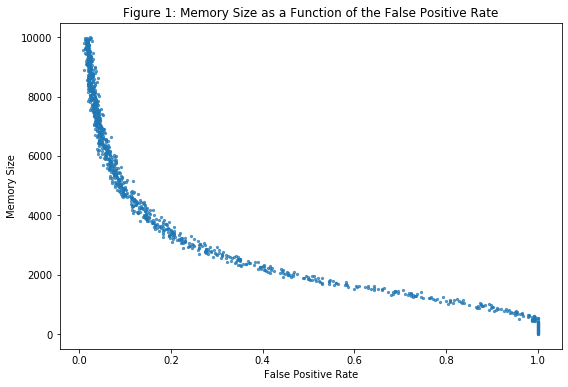

In [10]:
# Lists for graphing
memory = []
memory_formulas = []
fpr_list = []

# We need to keep the initial storage constant. 
storage_initially = 1000 

# For different memory sizes.
for i in range(1, 10000, 10):

    # Appending the memory size.
    memory.append(i)
    
    # Creating the CBF. 
    cbf = CBF(i, 3) # Using three hash functions. 
    
    # Finding the fpr rate. 
    rate = find_fpr(cbf, storage_initially)
    fpr_list.append(rate)
    
plot1 = plt.figure(1)
plt.figure(figsize = (9, 6))
plt.scatter(fpr_list, memory, alpha=0.7, s=5)
plt.title("Figure 1: Memory Size as a Function of the False Positive Rate")
plt.xlabel("False Positive Rate")
plt.ylabel("Memory Size")
plt.show()

In Figure 1, we can see that as the false positive rate increases, the memory size decreases. Thus, small arrays should have a bigger false-positive error and therefore be more prone to errors. With a higher false positive rate, we will have more collisions as we add new elements to the CBF, and the latter is more likely to happen with a smaller array/memory size. Conversely, if we want a low false-positive rate, we need to increase the array size significantly.

## b) Memory Size as a Function of the Number of Items Stored

In this case, we will interpret the memory size as the length of the CBF. Thus, we will examine how the latter relates to the number of items stored in the CBF. 

We will have to keep $p$ and $k$ constant. Keeping a constant number of hash functions, $k$, can quickly be done as we have it as an input. However, keeping the false positive rate, $p$, constant is more complicated. Therefore, to test this experimentally, we will determine a range of what values of $p$ we will allow. Here, we will only allow results with false positive rate in the range of 0% to 1%.

To graph, we use a for loop. In each iteration, we generate new CBFs with memory sizes in different ranges but with the same number of hash functions. Additionally, we also find the false positive rate for each of the different memory-length CBFs with the current number of items given by the for loop. Thus, by finding the false positive rate for CBFs with varying sizes of memory, we can save the results that fit our false positive range. The latter allows us to keep the false positive rate closer to constant. 

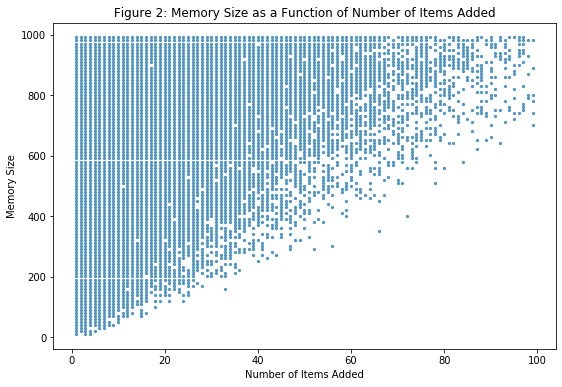

In [11]:
# Initializing the lists for the results.
items_number = []
memory_size = []

# Setting the max bound for the fpr.
f_max = 0.01

# Range of items to add.
for items in range(1, 100, 1):
    
    # Range of memory sizes. 
    memory_list = [x for x in range(1, 1000, 10)]
    
    # Creating CBFs for each memory size (same range as above) with k = 5. 
    CBFs = [CBF(size, 5) for size in range(1, 1000, 10)] 
    
    # Finding the fpr for each CBF with the current number of items. 
    fprs = [find_fpr(CBF, items) for CBF in CBFs]
    
    # Checking each of the results. 
    for index in range(len(fprs)):
        
        # Only allowing results with fpr <= the max fpr bound. 
        if fprs[index] <= f_max:
            memory_size.append(memory_list[index])
            items_number.append(items)
    
plt.figure(figsize = (9, 6))
plt.scatter(items_number, memory_size, alpha=0.7, s=5)
plt.title("Figure 2: Memory Size as a Function of Number of Items Added")
plt.xlabel("Number of Items Added")
plt.ylabel("Memory Size")
plt.show()

In the figure, we can see that when the number of items added increases, there are fewer options for memory size. For example, if we want to store one element, we can use all different kinds of memory sizes. However, if we want to store 40 items, then we will need a memory size of at least around 300 to keep the false positive rate below 1%. From the graph, we can see that the boundary for memory size seems to increase linearly as we increase the number of items added.

Furthermore, from the formula,  
<br />  
$m=-\frac{nlnp}{(ln2)^2}$  
<br />  
we can see that $m$ is linearly related to the items added ($n$) since we are keeping $p$ constant, which then also aligns with our results.

## c) Access Time as a Function of the False Positive Rate

Access time depends on how many hash functions we have. When searching for an element, the algorithm will evaluate the $k$ hash functions and thus check $k$ indices. As we increase the number of hash functions, we will also increase the access time. Therefore, with a constant number of hash functions, the access time should also stay constant, $O(1)$, (for one search) no matter what the false positive rate is.   

We can analyze this situation with different experimental plots. First, we vary the number of items added as a way to alter the false positive rate. Next, we modify the memory size to change the false positive rate. Lastly, we use the first implementation of the CBF to alter the number of hash functions while letting the algorithm determine the memory size. 

### Access Time as a Function of the False Positive Rate while Varying Items Added

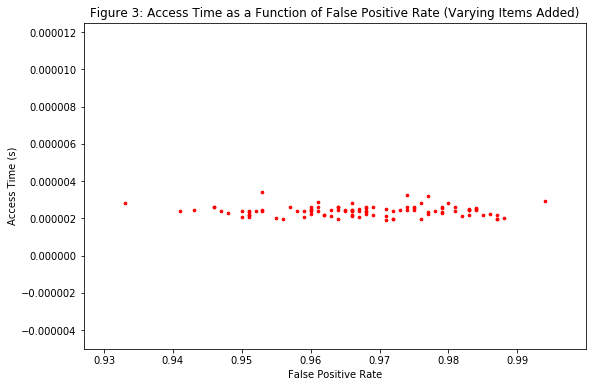

In [12]:
# Lists for graphing. 
fpr_list = []
access_time_there = []
items_list_d = []

memory_size = 1000
k = 5
trials = 5

for item in range(1, 1000, 10):
    
    # Creating an items list.
    items_list_d.append(item)
    
    # Creating a CBF. 
    cbf = CBF(1000, k)

    # Initializing the counters. 
    false_positive = 0
    true_negative = 0
    
    # Creating a list of random words to insert. 
    inserted_words = [randomword_lower() for word in range(memory_size)]
    
    # Creating a list of words we know are not in the array.
    words_not_there = [randomword_upper() for word in range(memory_size)]
    
    # Inserting words into the CBF
    for current_word in inserted_words:
        cbf.add(current_word)
    
    # Selecting words.
    word_there = inserted_words[0]
    word_not_there = words_not_there[0]
    
    # List so that we can average the time. 
    times_trials_there = []
    
    # Finding the average search time over several trials. 
    for i in range(trials): 
        
        # Timing how long it takes to search for the word.
        start_time = time.time()
        cbf.contains(word_there)
        end_time = time.time()
        times_trials_there.append(end_time - start_time)
    
    # Averaging.
    access_time_there.append(sum(times_trials_there) / trials)
    
    # Finding the false positive rate for the current CBF. 
    for word in words_not_there:

        # If we "found" the word in the CBF but the word is not in the word list
        # then we have a false positive. 
        if cbf.contains(word) == True and word not in inserted_words:
            false_positive += 1

        # Otherwise, we have a true negative. 
        else:
            true_negative += 1

    # Finding the false positive rate:
    fpr = false_positive/(false_positive + true_negative)
    fpr_list.append(fpr)

plt.figure(figsize = (9, 6))
plt.scatter(fpr_list, access_time_there, alpha=1, s=7, color="red")
plt.ylim(-0.000005, 0.0000125)
plt.title("Figure 3: Access Time as a Function of False Positive Rate (Varying Items Added)")
plt.xlabel("False Positive Rate")
plt.ylabel("Access Time (s)")
plt.show()

### Access Time as a Function of the False Positive Rate while Varying Memory Size

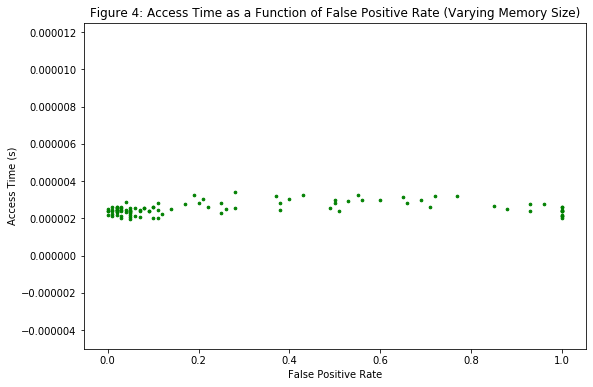

In [13]:
fpr_list = []
access_time = []
memory_size_list = []

items_insert = 100
k = 5

for memory_size in range(1, 1000, 10):
    
    # Creating a memory size list.
    memory_size_list.append(memory_size)
    
    # Creating a CBF. 
    cbf = CBF(memory_size, k)

    # Initializing the counters. 
    false_positive = 0
    true_negative = 0
    
    # Creating a list of random words to insert. 
    inserted_words = [randomword_lower() for word in range(items_insert)]
    
    # Creating a list of words we know are not in the array.
    words_not_there = [randomword_upper() for word in range(items_insert)]
    
    # Inserting words into the CBF
    for current_word in inserted_words:
        cbf.add(current_word)
    
    # Selecting a word we know is in the CBF.
    selected_word = inserted_words[0]

    # List so that we can average the time. 
    times_trials = []
    
    # Finding the average search time over several trials. 
    for i in range(trials): 
        
        # Timing how long it takes to search for the word.
        start_time = time.time()
        cbf.contains(selected_word)
        end_time = time.time()
        times_trials.append(end_time - start_time)
        
    access_time.append(sum(times_trials) / trials)
    
    # Finding the false positive rate for the current CBF. 
    for word in words_not_there:

        # If we "found" the word in the CBF but the word is not in the word list
        # then we have a false positive. 
        if cbf.contains(word) == True and word not in inserted_words:
            false_positive += 1

        # Otherwise, we have a true negative. 
        else:
            true_negative += 1

    # Finding the false positive rate:
    fpr = false_positive/(false_positive + true_negative)
    fpr_list.append(fpr)

plt.figure(figsize = (9, 6))
plt.scatter(fpr_list, access_time, alpha=1, s=7, color="green")
plt.ylim(-0.000005, 0.0000125)
plt.title("Figure 4: Access Time as a Function of False Positive Rate (Varying Memory Size)")
plt.xlabel("False Positive Rate")
plt.ylabel("Access Time (s)")
plt.show()

### Access Time as a Function of the False Positive Rate while Varying Number of Hash Functions

In this case, we will use the first implementation of the CBF, which allows us to vary the false positive rate and let the algorithm determine the number of hash functions along with the length of the CBF. 

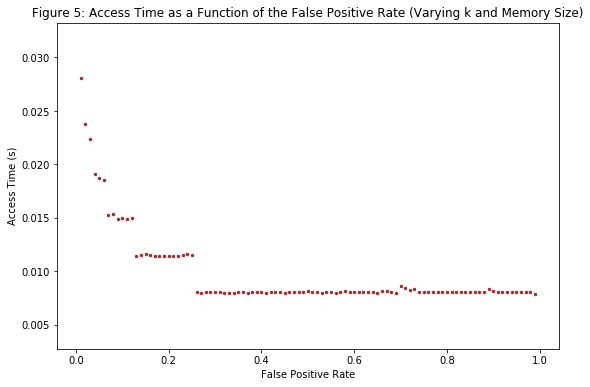

In [14]:
#List of fpr from 0.01 to 0.99
fpr = [p/100 for p in range(1,100)]
access_time = []

# Determine number of items to store.
items = 10000

# Number of time trials. 
trials = 10

# Going through each fpr
for rate in fpr:
    
    # Creating the CBF.
    cbf = CBF_formulas(items, rate)
    
    # Generating words to store.
    words_insert = [randomword_lower() for word in range(items)]
    
    # Inserting words
    for word in words_insert:
        cbf.add_formulas(word)
    
    # List for averaging. 
    current_times = []
        
    for i in range(trials):
        
        # Measure the searching time. 
        start_time = time.time()
        
        for word in words_insert:
            cbf.contains_formulas(word)
            
        end_time = time.time()
        
        total = (end_time - start_time)
        current_times.append(total)
    
    # Averaging the results and appending. 
    access_time.append(sum(current_times) / trials)

plt.figure(figsize = (9, 6))
plt.scatter(fpr, access_time, alpha=1, s=6, color="brown")
plt.xlabel("False Positive Rate")
plt.ylabel("Access Time (s)")
plt.title("Figure 5: Access Time as a Function of the False Positive Rate (Varying k and Memory Size)")
plt.show()

From the initial analysis, we determined that the access time should stay constant when the number of hash functions is not altered. Figure 3 shows a graph of the access time as a function of the false positive rate while only changing the number of items inserted. Here, we define the access time as the time it takes to search for an element we know is in the CBF. In the figure, we can see that the access time is approximately the same no matter what the false positive rate is. 

Figure 4 depicts the relationship between the access time as a function of the false positive rate but with varying memory sizes. Similarly to Figure 3, we also have approximately the same access time in the range of 0.000002 and 0.000004 seconds. Thus, both figures support the theory that if we have a constant number of hash functions, a change in insertion or memory should not change the access time. 

Lastly, Figure 5 shows the access time as a function of the false positive but with a varying number of hash functions along with a different memory size determined by the appropriate formula (using the first implementation of the CBF class). Here, we can see that as the false positive rate increases from 0 to around 0.3, the access time decreases. However, from a false positive rate of 0.3 to 1, the access time is approximately constant. We saw earlier that the following formula determines the size of the array:  
<br />  
$m=-\frac{nlnp}{(ln2)^2}$  
<br />  
Thus, as we increase the desired false positive rate, we need a bigger memory size. We also saw that the optimal number of hash functions is given by:  
<br />  
$k=\frac{m}{n}ln2=-\log_2 p$  
<br />  
Therefore, when we increase the desired false positive rate, we need a smaller amount of hash functions. Since the function is logarithmic and negative, we will see a sharp decrease in the number of required hash functions as we increase the false positive rate. Some examples:

- A false-positive rate of 0.001 ≈ 10 hash functions
- A false-positive rate of 0.1 ≈ 3 hash functions. 
- A false-positive rate of 0.3 ≈ 2 hash functions
- A false-positive rate of 0.9 ≈ 1 hash functions

If we solve the equation:  
<br />  
$-\log_2 p \geq 1$  
<br />  
We have that:  
<br />  
$p \geq 0.5$  
<br />  
Thus, for a p greater than or equal to 0.5, we need one hash function (as k cannot be smaller than one - we need at least one hash function). 

In the graph, we can also see that for a false positive rate of 0.5 and above, the access time is approximately the same because we have the same number of hash functions (k = 1). On the other hand, for a low false-positive rate, we need more hash functions, which increases our access time. 
 
Overall, all graphs support the conclusion that the access time depends on the number of hash functions. For each hash function, we have a constant access time, $O(1)$. Therefore, a greater number of hash functions leads to larger access time. In turn, if we vary k and the memory size, a lower false positive rate will have a greater access time because it requires more hash functions.

## d) Access time as a function of the number of items stored

Simiarly, to above, the access time depends on the number of hash functions and therefore not on the number of items stored. 

The number of hash functions is given by:  
<br />  
$k=\frac{m}{n}ln2$  
<br />  
and we also know that memory can be found through this formula:  
<br />  
$m=-\frac{nlnp}{(ln2)^2}$  
<br />  
Substituting the second equation into the first cancels $n$ and leaves us with:  
<br />  
$k=-\log_2 p$  
<br />  
Which also shows that the access time is not impacted by the number of items stored. If it was, $n$ would be a part of the last equation. 

We also saw this relationship in Figure 3, where the access time is graphed as a function of the false positive rate while we vary the number of items added. The graph can also be altered to show the access time as a function of the items stored.

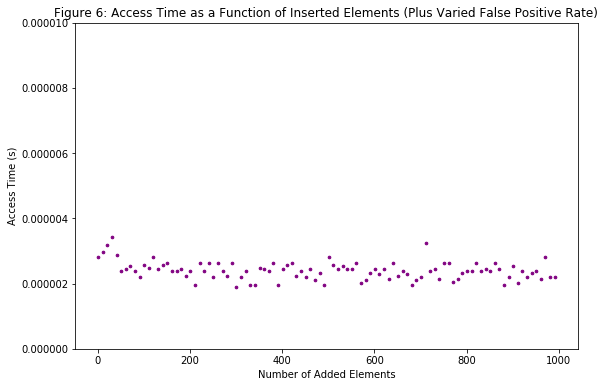

In [15]:
plt.figure(figsize = (9, 6))
plt.scatter(items_list_d, access_time_there, alpha=1, s=7, color="purple")
plt.ylim(0, 0.00001)
plt.title("Figure 6: Access Time as a Function of Inserted Elements (Plus Varied False Positive Rate)")
plt.xlabel("Number of Added Elements")
plt.ylabel("Access Time (s)")
plt.show()

In Figure 6, we can see that the access time when $k$ and $m$ are kept constant is approximately the same. We know that the CBFs created will have different false positive rates, but we still have almost constant access time.

### Corner Case Analysis
We do need to consider a corner case, which happens when we search for an element that is not in the CBF. In our implementation, when we search for a not present element, the search will terminate as soon as we find a 0. When we only have one hash function, the access time would still be $O(1)$ because we only need to look through one hash function. However, when we have more than one hash function, we might need to evaluate more than one hash function before we encounter a 0. 

We can try to experiment by plotting the access time for a present and not present element. 

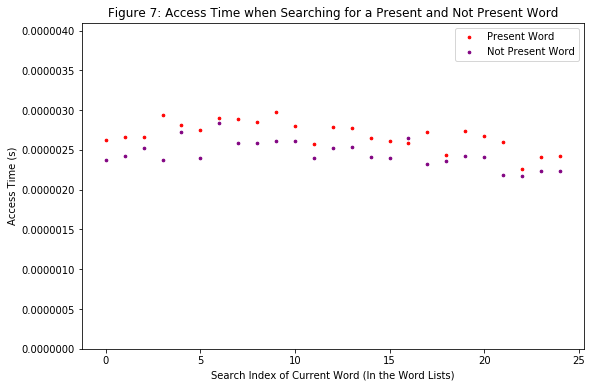

In [16]:
memory_size = 10000
number_words = 500
k = 30

# Creating a list of random words to insert. 
inserted_words = [randomword_lower() for word in range(number_words)]
    
# Creating a list of words we know are not in the array.
words_not_there = [randomword_upper() for word in range(number_words)]

# Determining how many times we want to search for the words. 
searches = 25
searches_list = []

# Creating the CBF
cbf = CBF(memory_size, 5)

# Inserting words into the CBF
for current_word in inserted_words:
    cbf.add(current_word)

access_time_there = []
access_time_not_there = []

trials = 750

for i in range(searches):
    
    # Appending the current search. 
    searches_list.append(i)
    
    # Lists so that we can average the time. 
    times_trials_there = []
    times_trials_not_there = []
    
    # Selecting words.
    word_there = inserted_words[i]
    word_not_there = words_not_there[i]
    
    # Finding the average search time over several trials. 
    for i in range(trials): 
        
        # Timing how long it takes to search for the present word.
        start_time = time.time()
        cbf.contains(word_there)
        end_time = time.time()
        times_trials_there.append(end_time - start_time)
        
        # Timing how long it takes to search for the not present word.
        start_time = time.time()
        cbf.contains(word_not_there)
        end_time = time.time()
        times_trials_not_there.append(end_time - start_time)
    
    # Averaging
    access_time_there.append(sum(times_trials_there) / trials)
    access_time_not_there.append(sum(times_trials_not_there) / trials)

plt.figure(figsize = (9, 6))
plt.scatter(searches_list, access_time_there, alpha=1, s=7, color="red", label="Present Word")
plt.scatter(searches_list, access_time_not_there, alpha=1, s=7, color="purple", label="Not Present Word")
plt.ylim(0.00000, 0.0000041)
plt.legend(loc='upper right')
plt.title("Figure 7: Access Time when Searching for a Present and Not Present Word")
plt.xlabel("Search Index of Current Word (In the Word Lists)")
plt.ylabel("Access Time (s)")
plt.show()

In the code above, we first generate a CBF and insert words into it. Next, we find one word we know is in the CBF, and one word we know is not there. Then, we search for the specified words and determine how long time the search takes (we search for the words several times and average the results). Next, we identify new words and go through the process again. Here, we keep the CBF characteristics constant and only change which words we are searching for. 

In Figure 6, the x-axis depicts the search index. Thus, a change in the x-axis means that we are searching for the next present word and not present word in the corresponding word lists. The red dots represent the access time for a present word and the purple dots for a not present word. 

Since we are searching for words within the same CBF, a search for a present word should take approximately the same time across all search indices. This is the case because we always have to check all the hash functions. However, a search for a not present word should, on average, take less time because we might not need to check all hash functions before we encounter a 0. 

To show this effect more clearly, we need to exaggerate the number of hash functions a bit; otherwise, the time difference would be negligible. In this case, k = 30, and we can see that searching for present words generally takes more time than searching for a not present word. Of course, there are cases where the search time is almost equal because, for a not present word, we might still encounter the worst-case where we have to check all hash functions. Furthermore, we might also check all hash functions for a not present word and never encounter a zero, corresponding to a false positive. 

### Conclusion for d)
Overall, we saw that the access time should not change if the number of items stored changes because the access time depends on the number of hash functions. However, from the last graph, we saw that there might be a slight time difference when searching for a present and not present element because the latter search might terminate earlier. Still, to really see a time difference, we need to increase $k$, and using such a large value might not happen often. Therefore, on a larger scale, we can still consider the access time to be $O(1)$ especially with smaller numbers of $k$.  

## Theoretical and Experimental False Positive Rate 

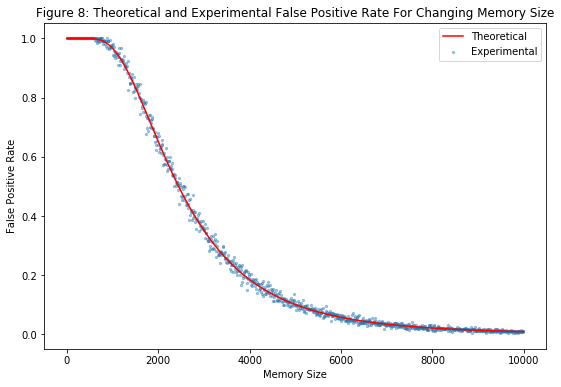

In [17]:
# Lists for graphing
memory = []
fpr_list = []
formula_fpr = []

# Keeping k constant. 
k = 5

# We need to keep the initial storage constant (n). 
storage_initially = 1000 

# For different memory sizes.
for i in range(1, 10000, 10):

    # Appending the memory size.
    memory.append(i)
    
    # Creating the CBF. 
    cbf = CBF(i, k) # Using three hash functions. 
    
    # Determining the false positive rate experimentally.
    rate = find_fpr(cbf, storage_initially)
    fpr_list.append(rate)
    
    # Using the formula for the false positive rate. 
    formula = (1-(1-(1/i))**(storage_initially*k))**k
    formula_fpr.append(formula)
    
plt.figure(figsize = (9, 6))
plt.scatter(memory, fpr_list, alpha=0.4, s=5, label="Experimental")
plt.plot(memory, formula_fpr, color="red", label="Theoretical")
plt.title("Figure 8: Theoretical and Experimental False Positive Rate For Changing Memory Size")
plt.xlabel("Memory Size")
plt.ylabel("False Positive Rate")
plt.legend(loc='upper right')
plt.show()

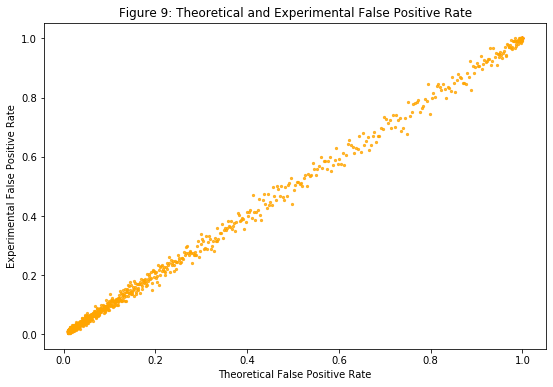

In [18]:
plt.figure(figsize = (9, 6))
plt.scatter(formula_fpr, fpr_list, alpha=0.8, s=5, color="orange")
plt.title("Figure 9: Theoretical and Experimental False Positive Rate")
plt.xlabel("Theoretical False Positive Rate")
plt.ylabel("Experimental False Positive Rate")
plt.show()

Figure 8 shows the theoretical and experimental false positive rate for different memory sizes, and we can see that they follow each other quite well. The relationship can also be shown by graphing the theoretical and experimental rates against each other, which has been done in Figure 9. Here, we can see that the relationship is linear, which also supports the conclusion that the experimental and theoretical rates are similar. 

## Corner Cases for CBFs

### Present vs. Not Present Elements 
One corner case concerning access time is searching for a present vs. not present element in the CBS. This has already been discussed in question 4d. We can also extend the analysis to deleting elements. In this case, deleting an element also requires searching for the element, and as the search for a not present element can have different termination points, trying to delete a not present element could also take different times.  

### Deleting an Item Which Is Not Present
Another corner case can happen when we delete an element. For example, we might have a CBF where all the counters have been incremented above the threshold (usually zero). If we then try to delete an element that is actually not present in the array, we would first have to search for it. Since all counters are above the threshold, the algorithm will tell us that the element is present, and it will ”delete" the entry. Thus, we are deleting an element that is not actually there. If the latter happens, we might not be able to delete an element we know was inserted because the counters have been already been decreased. 

# References

- Bloom filter. (2019, November 2). Retrieved November 3, 2019, from https://en.wikipedia.org/wiki/Bloom_filter.

- Bloom Filters - Introduction and Python Implementation. (2018, February 8). Retrieved November 3, 2019, from https://www.geeksforgeeks.org/bloom-filters-introduction-and-python-implementation/.

- Counting Bloom filter. (2019, July 29). Retrieved November 3, 2019, from https://en.wikipedia.org/wiki/Counting_Bloom_filter.

- Hassan, A. S. (2017, December 3). Probabilistic Data structures: Bloom filter. Retrieved November 1, 2019, from https://hackernoon.com/probabilistic-data-structures-bloom-filter-5374112a7832.

- Kim, K., Jeong, Y., Lee, Y., & Lee, S. (2019). Analysis of Counting Bloom Filters Used for Count Thresholding. Electronics, 8(7), 779. Retrieved November 1, 2019, from https://www.mdpi.com/2079-9292/8/7/779/htm.

- Li, W., Huang, K., Zhang, D., & Qin, Z. (2013). Accurate counting bloom filters for large-scale data processing. Mathematical Problems in Engineering, 2013. Retrieved November 1, 2019, from https://www.hindawi.com/journals/mpe/2013/516298/.

- mmh3. (n.d.). Retrieved November 3, 2019, from https://pypi.org/project/mmh3/.